<a href="https://colab.research.google.com/github/abduljawwad/mutli-ai-agent-customer-support-application/blob/main/mutli_ai_agent_customer_support_app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Following steps were involved in making this app:**

1.   Initialisation
2.   State Definition
3.   Instantiate llm
3.   Define node functions
4.   Workflow Compilation
5.   Query Execution


In [2]:
!pip install langchain langchain_core langchain_groq langchain_community langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.6/411.6 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 3.7 MB/s eta 0:00:00
  Attempting uninstall: langchain_core
    Found existing installation: langchain-core 0.3.25
    Uninstalling langchain-core-0.3.25:
      Successfully uninstalled langchain-core-0.3.25
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.12
    Uninstalling langchain-0.3.12:
      Successfully uninstalled langchain-0.3.12


In [3]:
from typing import TypedDict, Dict
from langgraph.graph import StateGraph, END
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import Image, display

Define State Structure

In [4]:
class State(TypedDict):
  query: str
  category: str
  sentiment: str
  response: str

Instantiates the `llama-3.3-70b-versatile` model from ChatGroq. Please ensure to place `groq_api_key.txt` file with a valid API key in Google Drive under `My Drive` folder





In [23]:
from langchain_groq import ChatGroq
from google.colab import drive

drive.mount('/content/drive')

with open('/content/drive/My Drive/groq_api_key.txt', 'r') as f:
  groq_api_key = f.read().strip()

llm = ChatGroq(
    temperature=0,
    verbose=True,
    groq_api_key = groq_api_key,
    model='llama-3.3-70b-versatile'
)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Define Node Functions

In [25]:
def categorize(state: State) -> State:
  "Categorizes the customer's query as either Technical, Billing, or General"
  prompt = ChatPromptTemplate.from_template(
    """
    Categorize the following customer's query into one of these categories:
    - Technical
    - Billing
    - General

    customer's query: {query}

    Respond with the category only.
    """
  )
  chain = prompt | llm
  state["category"] = chain.invoke({"query": state["query"] }).content
  return state

def analyze_sentiment(state: State) -> State:
  """Analyzes the sentiment of the customer's query.

  Classifies the sentiment as either Positive, Negative, or Neutral.
  Updates the input 'state' with the extracted sentiment.

  Args:
    state: A dictionary containing the customer's query under the "query" key.

  Returns:
    The updated 'state' dictionary with the sentiment added under the "sentiment" key.
  """
  prompt = ChatPromptTemplate.from_template(
    """
    Analyze and classify the sentiment of the customer's query into one of the following categories:
    - Positive
    - Negative
    - Neutral

    customer's query: {query}

    Respond with the category only.
    """
  )
  chain = prompt | llm
  state["sentiment"] = chain.invoke({"query": state["query"] }).content
  return state

def generate_technical_response(state: State) -> State:
  "Generates a technical response for the customer's query"
  prompt = ChatPromptTemplate.from_template(
    """
    Please generate a clear step-by-step technical support response in markdown format for the following customer's query:

    customer's query: {query}
    """
  )
  chain = prompt | llm
  state["response"] = chain.invoke({"query": state["query"] }).content
  return state

def generate_billing_response(state: State) -> State:
  "Generates a billing response for the customer's query"
  prompt = ChatPromptTemplate.from_template(
    """
    Please generate a clear step-by-step billing support response for the following customer's query:

    customer's query: {query}
    """
  )
  chain = prompt | llm
  state["response"] = chain.invoke({"query": state["query"] }).content
  return state

def generate_generic_response(state: State) -> State:
  "Generates a generic response for the customer's query"
  prompt = ChatPromptTemplate.from_template(
    """
    Please generate a clear step-by-step generic support response for the following customer's query:

    customer's query: {query}
    """
  )
  chain = prompt | llm
  state["response"] = chain.invoke({"query": state["query"] }).content
  return state

def escalate_query(state: State) -> State:
  "Escalates the customer's query to the customer support team"
  state["response"] = "This query has been escalated to the customer support team because of it's negative sentiment."
  return state

def route_query(state: State) -> State:
    """Routes the customer's query to the appropriate support response."""
    if state.get('sentiment') == 'Negative':
        return 'Escalate'  # Go to Escalate node
    elif 'category' not in state:
        return 'Categorize'  # Go to Categorize node if category is not determined
    elif state['category'] == 'Technical':
        return 'Technical query'  # Go to Technical query node
    elif state['category'] == 'Billing':
        return 'Billing query'  # Go to Billing query node
    else:
        return 'Generic query'

Create and configure the workflow graph

In [26]:
workflow= StateGraph(State)

workflow.add_node('Analyze Sentiment', analyze_sentiment)
workflow.add_node('Categorize', categorize)
workflow.add_node('Technical query', generate_technical_response)
workflow.add_node('Billing query', generate_billing_response)
workflow.add_node('Generic query', generate_generic_response)
workflow.add_node('Escalate', escalate_query)

workflow.add_conditional_edges('Analyze Sentiment', route_query, {
    'Escalate': 'Escalate',
    'Categorize': 'Categorize'
})

workflow.add_conditional_edges('Categorize', route_query, {
    'Technical query': 'Technical query',
    'Billing query': 'Billing query',
    'Generic query': 'Generic query',
})

workflow.add_edge('Escalate', END)
workflow.add_edge('Technical query', END)
workflow.add_edge('Billing query', END)
workflow.add_edge('Generic query', END)

workflow.set_entry_point('Analyze Sentiment')

app = workflow.compile()

Visualize the workflow graph

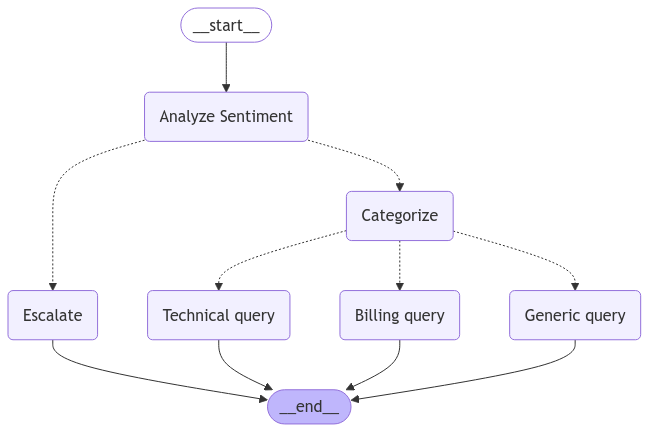

In [27]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

Define and run customer support function with a customer query

In [28]:
def run_customer_support(query:str) -> Dict[str, str]:
  result = app.invoke({'query': query})
  return {
      'query': query,
      'category': result.get('category', None),
      'sentiment': result.get('sentiment', None),
      'response': result['response']
  }

In [29]:
  query = 'How can I resolve issues with my ISP?'
  run_customer_support(query)

{'query': 'How can I resolve issues with my ISP?',
 'category': 'Technical',
 'sentiment': 'Neutral',
 'response': '### Resolving Issues with Your Internet Service Provider (ISP)\n#### Step 1: Identify the Issue\nBefore contacting your ISP, try to identify the nature of the problem. Ask yourself:\n* Is your internet connection slow or intermittent?\n* Are you experiencing issues with a specific website or online service?\n* Have you recently made any changes to your network or hardware?\n\n#### Step 2: Restart Your Router\nRestarting your router can often resolve connectivity issues. To do this:\n1. Unplug the power cord from the back of the router.\n2. Wait for 30 seconds to allow any residual power to drain.\n3. Plug the power cord back in and turn on the router.\n4. Wait for the router to boot up and stabilize (this may take a few minutes).\n\n#### Step 3: Check for Outages in Your Area\nVisit your ISP\'s website or social media pages to check for any reported outages in your area. 